## Incident handling at Kayako

We at Kayako strive for the number of 9's in our uptime metric. We want to ensure minimum service disruption for our customers, and therefore we need to work hard on the following two aspects: 

1. Identifying that an incident has occurred 
2. Minimizing the impact of the incident


### Identifying an incident

Our goal is to identify an incident before our customer. It not only helps us in proactively informing our customers on the ongoing issues but also helps us to prepare our Support team better for the incoming queries. It is a step towards better customer experience, which is what Kayako is all about.

To achieve this goal, we have monitoring at multiple levels in our entire infra, and we are improving it continuously. Most of these monitoring tools are either integrated with [Slack](https://medium.com/life-at-kayako/staying-on-top-of-our-stack-with-slack-e72c34a0b090#.vj5q9wig6) or Pagerduty so that our SRE team is the first one to know about these incidents.

Some of the things that we currently monitor are:

1. Health of our servers (like load, memory-usage, io wait, etc.)
2. Health of individual Kayako helpdesks (crons, emails, search, queues, realtime dispatch, etc.)
3. Connectivity within our infra (for ex: if application is able to connect to the Database)
4. Health of Database
5. Any delays in outgoing emails
6. Spam alerts
7. Health of our microservices
8. Trial sign-ups failures 
9. Timely DB backups
10. Any suspicious activity
11. Health of critical processes like Nginx, supervisord, etc.

...and the list goes on. Once we have identified an incident, it brings up to the next step:

### Minimizing the impact of an incident

Incidents are inevitable, things do go wrong, but our goal is to minimize the impact on our customers. We have a Standard Operating Procedure (SOP) around incidents response, and one of the critical parts of that SOP is an _issue_ channel.

We create a channel on Slack for every new incident (called an "issue" channel), all the relevant stakeholders join that channel, and all the discussion about the incident happen only in that channel. The issue channel remains open until we do a post-mortem, find the root cause of the issue and fix it. The channel is archived once we fix the root cause.

Before I go into the details of our SOP, let's first start by listing down all the issue channels that we currently have. We follow convention as #issue-topic-ddmm. So if there is an issue with our crons on 12th March 2016, we will create a channel #issue-cron-1203.

In [66]:
import requests
import json

slack_token = 'xxx'
slack_channel_list = 'https://slack.com/api/channels.list'

# Let's first fetch all the channels from the Slack API
r = requests.get(slack_channel_list, params={'token': slack_token})

# and load them into a JSON object
channels = json.loads(r.text)

# Now let's filter out the issue channels from all the channels
issue_channels = list(filter(lambda x: x["name"].startswith("issue-"), channels.get("channels")))

# Let's see how many channels do we have
print(len(issue_channels))

207


#### 207, that's a lot of issues!

But before we conclude anything, let's see what is the time range in which these channels span:

In [61]:
from datetime import datetime

# We will sort these channels by created date, which is a unix-timestamp
issue_channels = sorted(issue_channels, key = lambda x: x['created'])

# Let's pick the first and the last created channel
first_channel = issue_channels[0]
last_channel = issue_channels[-1]

# Let's look at the average number of issue channels per month
# Since the timestamp is in seconds, therefore we convert it to months
total_months = (last_channel['created'] - first_channel['created']) / (60 * 60 * 24 * 30)

average = int(len(issue_channels) / total_months)

print("First issue channel: " + str(datetime.fromtimestamp(first_channel['created'])))
print("Last issue channel: " + str(datetime.fromtimestamp(last_channel['created'])))
print("Average number of issue channels per month: " + str(average))

First issue channel: 2016-03-11 06:55:23
Last issue channel: 2017-03-23 00:43:10
Average number of issue channels per month: 16


Let's see how many of these issue channels are active as of now:

In [62]:
active_issue_channels = list(filter(lambda x: not x["is_archived"], issue_channels))
        
print(len(active_issue_channels))

3


#### Only 3 active issue channels!

Active not necessarily mean that the issue is ongoing, it can also mean that the issue is resolved, however, the root cause analysis is pending (which is the case here).

Do you want to know what was my worst day in the last one year? Let's find out

In [63]:
# Let's find out the maximum number of issue channels created in a day
from collections import OrderedDict

# We will create an ordered dictionary with tuples date and count
# The structure will look like: {(date, count), ...}

# Let's create the 'key' (date) for our tuple from timestamp
def get_date_from_timestamp(timestamp):
    return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

# Iterate over all the channels and count the channels created same day
channels_on_dates = OrderedDict()
for channel in issue_channels:
    creation_date = get_date_from_timestamp(channel['created'])
    
    if creation_date not in channels_on_dates.keys():
        channels_on_dates[creation_date] = 1
    else:
        channels_on_dates[creation_date] += 1

# Let's sort the dictionary based on number of channels
channels_on_dates = sorted(channels_on_dates.items(), key = lambda x: x[1])

# Let's print the maximum number of channels
print("Worst day in last year: " + str(channels_on_dates[-1][0]))
print("Total number of issue channels created on this date: " + str(channels_on_dates[-1][1]))

Worst day in last year: 2016-08-09
Total number of issue channels created on this date: 6


Let's try to analyze the trend of issue channels over time. To find a trend, we need to need to know the archive date of a channel, which is not present in the issue_channels list that we have. Fortunately, Slack has an API to get the archive date of a channel.

In [67]:
# Let's fetch archive date from history API
import math

slack_channel_history = 'https://slack.com/api/channels.history'

# This methods return archive date from channel ID
def get_archive_date(channel_id):
    r = requests.get(slack_channel_history, params={'token': slack_token, 'channel': channel_id})

    for message in json.loads(r.text).get('messages'):
        # This code assumes that archive key will be present in first paginatinated response
        # otherwise we simply assume that the channel is not archived yet
        if 'subtype' in message and message['subtype'] == 'channel_archive':
            return message['ts']
    
    return math.inf

for channel in issue_channels:
    channel['archived'] = get_archive_date(channel['id'])

Now we have archived dates in our issue_channels list. Let's try to plot the number of open issue channels over time in the given date range. To plot this, we will create a range of dates for X-axis and the number of issue channels that were open on that date on the Y axis.

In [68]:
import time

# Returns if the channel was open at a given timestamp
def was_open(channel, timestamp):
    return timestamp >= float(channel['created']) and timestamp <= float(channel['archived'])

def timestamp_to_date(timestamp):
    return datetime.fromtimestamp(timestamp)

# We will start X-axis date just before our first issue channel
start_timestamp = first_channel['created'] - 1000 # 1000 can be any positive value
end_timestamp = time.time()
interval = 60 * 60 * 24 * 30 # We will create a monthly interval

# Let's generate our X-axis
xaxis = list(range(int(start_timestamp), int(end_timestamp), interval))

# We might have skipped the current timestamp because it might have been
# overflowed the range, so let's add it explicitly
xaxis.append(int(time.time()))

yaxis = [] # we need to find the values

for date in xaxis:
    open_channels = 0
    for channel in issue_channels:
        if was_open(channel, date):
            open_channels += 1
        
    yaxis.append(open_channels)
    
# Convert convert the timestamps to actual dates
xaxis = list(map(timestamp_to_date, xaxis))

So we have our range on X-axis and the corresponding number of open issue channels on Y-axis. Let's plot them:

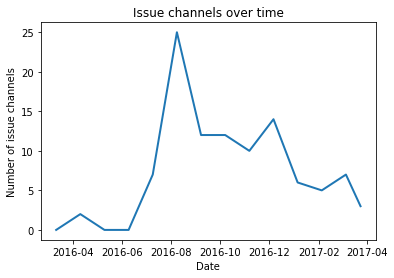

In [69]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.plot(xaxis, yaxis, linewidth=2.0)
plt.ylabel('Number of issue channels')
plt.xlabel('Date')

plt.title('Issue channels over time')
plt.autoscale(enable=True, tight=False)

plt.show()

#### Interpreting the graph

We launched The New Kayako in **July 2016**, and there was a steep rise in the number of issue channels. Just like with any other product launch, things were not so stable. We worked hard on fixing the root issues and making sure that the problems don't repeat. Whatever issues we encountered, they were fixed forever. The results you can see by yourself. There is a declining trend in the number of incidents. The system has become a lot more stable from where we started. We have spent countless nights to reach the current state.

By no way this is an ideal state, we are continuously improving and getting stable with every passing day.

#### Issue channels, hit or miss?

I would leave it to the readers to decide if this strategy was a success or a failure. I have shared a part of the data that we have on it.

#### Standard Operating Procedure for Incidents

Issue channel is just one of the many things that we follow to minimize the impact of an incident. Let me share some points from our SOP document on the incident response:

* Change your mindset - quickly say the following things to yourself.
    * This is an extreme situation and my normal behavior is not ideal in this context
    * The customer is suffering because of us and it is paramount to restore services first - anyway possible
    * We are not debugging, that is for later, we don’t care for root causes right now - only solutions
    * I will lose my sense of time as I start working, I must put a timer that repeats every 10 mins so I realize the passage of time
    * I may not be able to solve this alone
    * I don’t need to know everything before I escalate. If it’s time to escalate, I will do it even with incomplete information.
    * The escalation is a form of communication and the act alone has value.
    * I am not the only person impacted by this problem. I am not the only person worried about it. But I am the closest to the action and therefore all communication starts at me.

* Build context, answer the following questions as best as you can don’t spend more than two minutes on this
    * Which component seems to be the source of this problem?
    * What is the frequency or duration of this problem?
    * What other components are affected by this behaviour?
    * What is the severity of this issue? It’s critical or severe if one or more customers are facing a downtime
    
* In the issue channel set the topic to a brief line about the problem and add names for SRE issue owner and Developer/Product Engineer issue owner, as applicable

* Check the escalation matrix periodically and escalate as required

* Update issue channel with summary of issue, cover the following points, if something is not known say its ‘UNKNOWN’
    * Environment: Staging / Production
    * Component responsible for problem
    * Probable cause if known
    * Frequency or Duration of issue
    * Type: Self (Engineering), Unknown, Scale (any scalability problems etc), Vendor (AWS, Dynect, Sendgrid, Realtime etc)
    * Estimated Time to recovery (If Unknown, take an educated guess is it a matter of minutes, hours, or days)
    * Who is working to fix this
    * Current action step
    * Next action step

### Summary

Production outages are extreme pressure situations, in such situations, we try to:

* Communicate as much as possible – to engineering teams, to support teams or any other stakeholders
* Minimize the downtime and impact
* Leave trails for finding and fixing root cause right afterward
* Escalate as required

I mentioned some of the tools and processes that we use to achieve these goals. They are not perfect, and we keep them improving based on the feedback. If you have similar processes in your company, drop a comment below and let us know!